# first code 
### i have writen this code first i tried to run in on my laptop but this have to run for 2000 epochs to generate good result i tried to run it on a lab pc which i got access through anydesk but version of tensorflow was not matching because of which there is problem of loading pretraiend weights
### because of this i created another code this time on pytorch beacuse i found that i has less verison difficulties 

In [1]:
!pip install tensorflow  matplotlib tensorflow-datasets ipywidgets

In [2]:
import tensorflow as tf 

In [3]:
import tensorflow_datasets as tfds

In [4]:
from matplotlib import pyplot as plt

In [5]:
ds = tfds.load('fashion_mnist', split='train')

In [6]:
import numpy as np

In [9]:
dataiterator = ds.as_numpy_iterator()

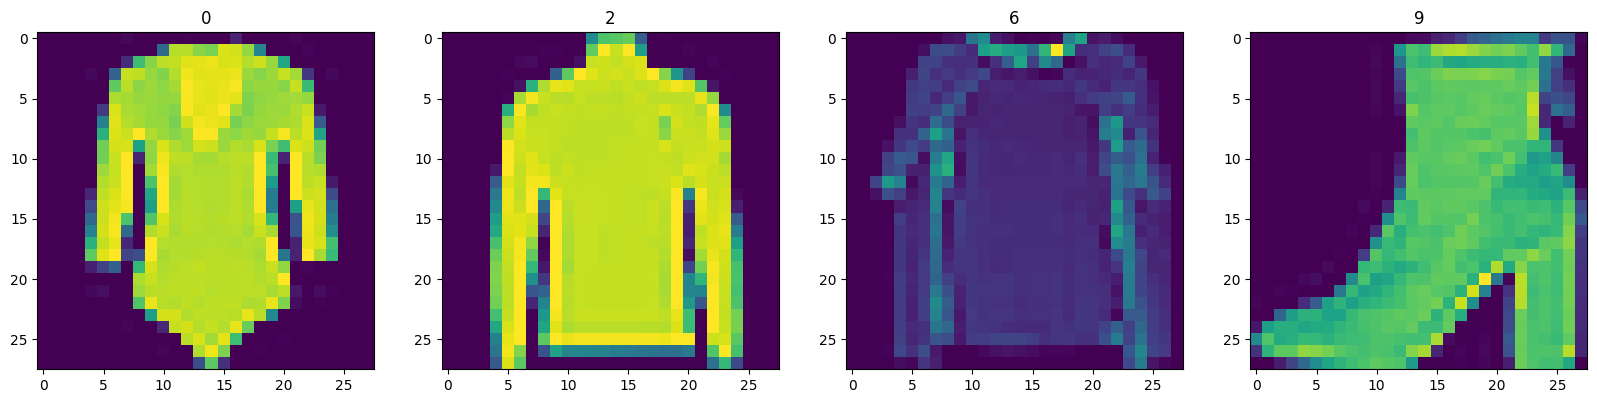

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample = dataiterator.next()
    ax[idx].imshow(np.squeeze(sample['image'])) 
    ax[idx].title.set_text(sample['label'])

In [14]:
def scale_images(data): 
    image = data['image']
    return image / 255

In [15]:
ds = ds.map(scale_images) 

In [16]:
ds = ds.cache()

In [17]:
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)


In [18]:
ds.as_numpy_iterator().next().shape


(128, 28, 28, 1)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [76]:
def build_generator():
    model = Sequential()

    model.add(Dense(7*7*128 , input_dim = 128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    model.summary()

    return model


In [77]:
generator = build_generator()
generator.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 6272)              809088    
                                                                 
 leaky_re_lu_51 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_7 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_14 (UpSamplin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_52 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                     

In [78]:
def build_discriminator(): 
    model = Sequential()
    
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_56 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_20 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_57 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_57 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_21 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_58 (Conv2D)          (None, 16, 16, 128)     

In [57]:
from tensorflow.keras.optimizers import Adam

In [58]:
from tensorflow.keras.losses import BinaryCrossentropy


In [59]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [60]:
from tensorflow.keras.models import Model

In [61]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        super().compile(*args, **kwargs)
        
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        with tf.GradientTape() as d_tape: 
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        with tf.GradientTape() as g_tape: 
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [79]:

fashgan = FashionGAN(generator, discriminator)
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [80]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [81]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [33]:
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20


2025-01-15 10:01:53.849846: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


324/469 [===================>..........] - ETA: 2:51 - d_loss: 0.4203 - g_loss: 2.4197

KeyboardInterrupt: 

In [82]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

NameError: name 'hist' is not defined

<Figure size 640x480 with 0 Axes>

In [83]:
weights_path = 'generatormodel.h5'


In [84]:
generator.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 6272)              809088    
                                                                 
 leaky_re_lu_51 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_7 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_14 (UpSamplin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_52 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                     

In [73]:
generator.load_weights(weights_path, by_name=True, skip_mismatch=True)


In [74]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 33ms/step


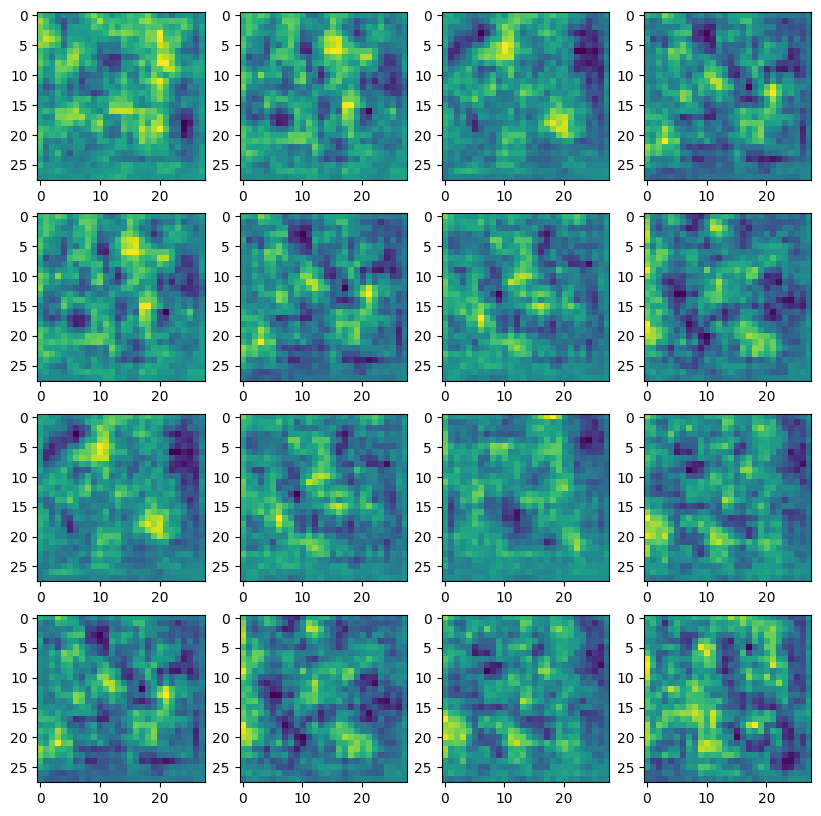

In [75]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])